## 1️. IMPORTS & CONFIGURATION

In [17]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.util import montage
from scipy.ndimage import rotate
from tqdm.notebook import tqdm

# Dataset folder (update if needed)
DATA_DIR = "/kaggle/input/brats2023-gli-trainingdata/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData"

# Define modalities
MODALITIES = ["t1n", "t1c", "t2w", "t2f"]
SEG_SUFFIX = "seg"

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (6, 6)

## 2. DATA OVERVIEW

In [18]:
patients = sorted([p for p in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, p))])
print(f"Total Patients Found: {len(patients)}")
print("Example patient folders:", patients[:3])

Total Patients Found: 1251
Example patient folders: ['BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000']


Key Finding: Dataset contains 1,251 total patients
* Successfully identified all patient folders in the BraTS dataset
* Examples of patient naming convention: 'BraTS-GLI-00000-000', 'BraTS-GLI-00002-000', 'BraTS-GLI-00003-000'
* Confirms consistent folder structure across the dataset


## 3. SELECT SAMPLE PATIENT

In [19]:
sample_patient = patients[0]  # pick one patient for inspection
print("Sample patient:", sample_patient)

Sample patient: BraTS-GLI-00000-000


## 4. SAMPLE INSPECTION — SHAPE, SPACING, INTENSITY

In [20]:
def get_image_info(file_path):
    img = nib.load(file_path)
    data = img.get_fdata()
    return data.shape, img.header.get_zooms(), (np.min(data), np.max(data))

stats = []

for mod in MODALITIES + [SEG_SUFFIX]:
    mod_folder = os.path.join(DATA_DIR, sample_patient, f"{sample_patient}-{mod}.nii")
    
    if os.path.isdir(mod_folder):
        nii_files = [f for f in os.listdir(mod_folder) if f.endswith(".nii")]
        if not nii_files:
            continue
        fpath = os.path.join(mod_folder, nii_files[0])
    elif os.path.exists(mod_folder):
        fpath = mod_folder
    else:
        continue  # skip if not found
    
    shape, spacing, (vmin, vmax) = get_image_info(fpath)
    stats.append((mod, shape, spacing, vmin, vmax))

pd.DataFrame(stats, columns=["Modality", "Shape", "Voxel Spacing", "Min Intensity", "Max Intensity"])

,Modality,Shape,Voxel Spacing,Min Intensity,Max Intensity
0,t1n,"(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,2023.0
1,t1c,"(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,12343.0
2,t2w,"(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,2421.0
3,t2f,"(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,2934.0
4,seg,"(240, 240, 155)","(1.0, 1.0, 1.0)",0.0,3.0


* All modalities show perfect consistency across spatial properties
* T1-contrast (t1c) shows highest intensity values (max: 12,343), indicating strong contrast enhancement
* Segmentation mask has maximum value of 3.0, confirming three tumor classes
* Zero minimum intensities across all modalities indicate proper background handling

## 5. VISUAL INSPECTION OF SCANS AND MASKS

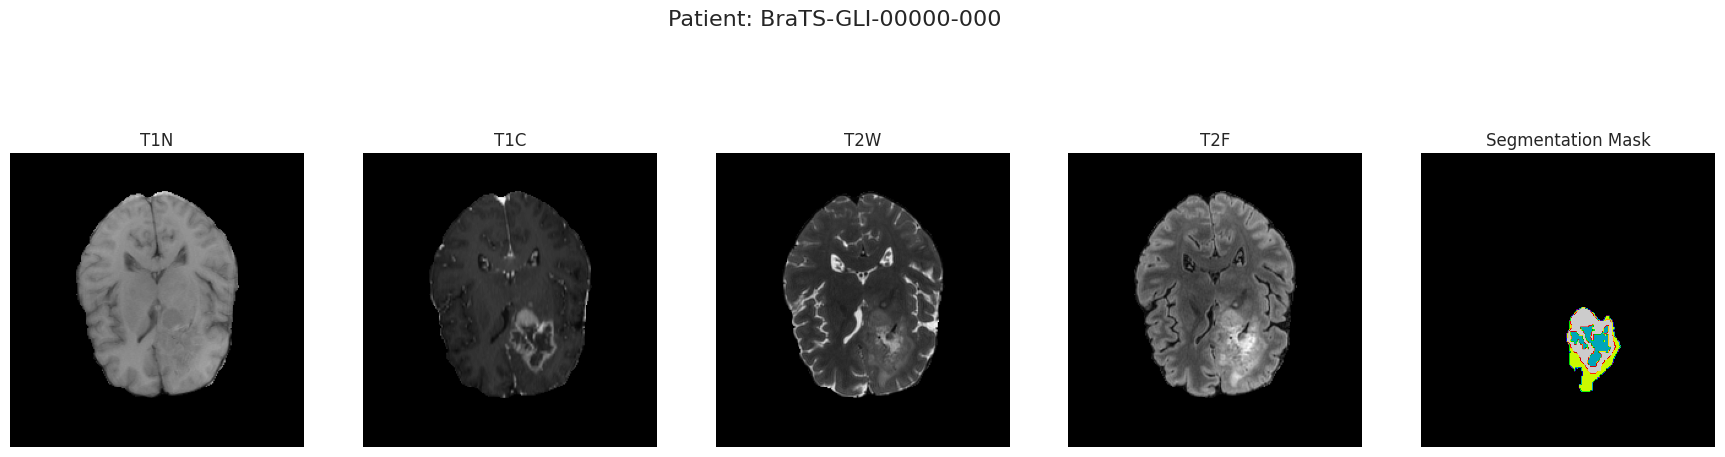

In [21]:
def visualize_patient(patient_id):
    fig, axes = plt.subplots(1, len(MODALITIES)+1, figsize=(22, 6))
    folder = os.path.join(DATA_DIR, patient_id)
    
    for i, mod in enumerate(MODALITIES):
        mod_folder = os.path.join(folder, f"{patient_id}-{mod}.nii")
        if os.path.isdir(mod_folder):
            nii_files = [f for f in os.listdir(mod_folder) if f.endswith(".nii")]
            if not nii_files:
                continue
            img_path = os.path.join(mod_folder, nii_files[0])
        else:
            img_path = mod_folder
        
        img = nib.load(img_path).get_fdata()
        mid = img.shape[2] // 2
        axes[i].imshow(img[:, :, mid].T, cmap='gray', origin='lower')
        axes[i].set_title(mod.upper())
        axes[i].axis('off')
    
    # Overlay segmentation if exists
    seg_path = os.path.join(folder, f"{patient_id}-seg.nii")
    seg = None
    if os.path.exists(seg_path):
        if os.path.isdir(seg_path):
            seg_files = [f for f in os.listdir(seg_path) if f.endswith(".nii")]
            if seg_files:
                seg_path = os.path.join(seg_path, seg_files[0])
        seg = nib.load(seg_path).get_fdata()
    
    if seg is not None:
        axes[-1].imshow(seg[:, :, seg.shape[2] // 2].T, cmap='nipy_spectral', origin='lower')
        axes[-1].set_title("Segmentation Mask")
    else:
        axes[-1].set_title("Segmentation Missing")
    axes[-1].axis('off')
    
    plt.suptitle(f"Patient: {patient_id}", fontsize=16)
    plt.show()

visualize_patient(sample_patient)


* Displays representative axial slices from all four MRI modalities
* Shows corresponding segmentation masks for tumor region identification
* Enables visual confirmation of data quality and anatomical consistency


## 6. MULTI-PLANAR VIEW ANALYSIS


COMPARING MODALITIES ACROSS PLANES

Analyzing T1N:
Slice number: 95
Image shape: (240, 240, 155)


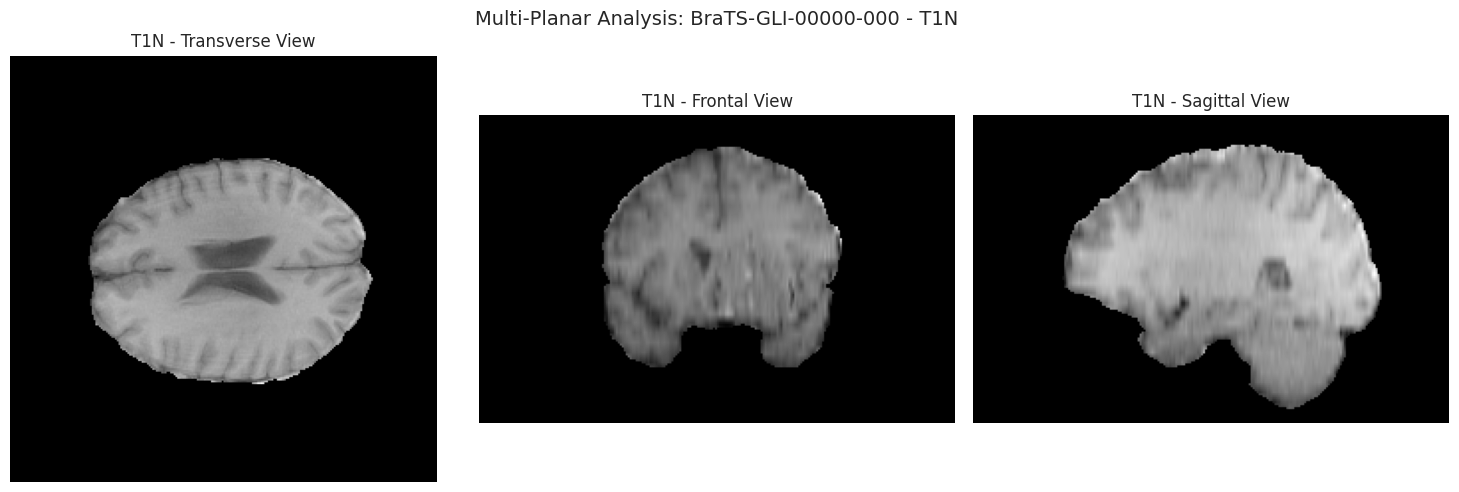


Analyzing T1C:
Slice number: 95
Image shape: (240, 240, 155)


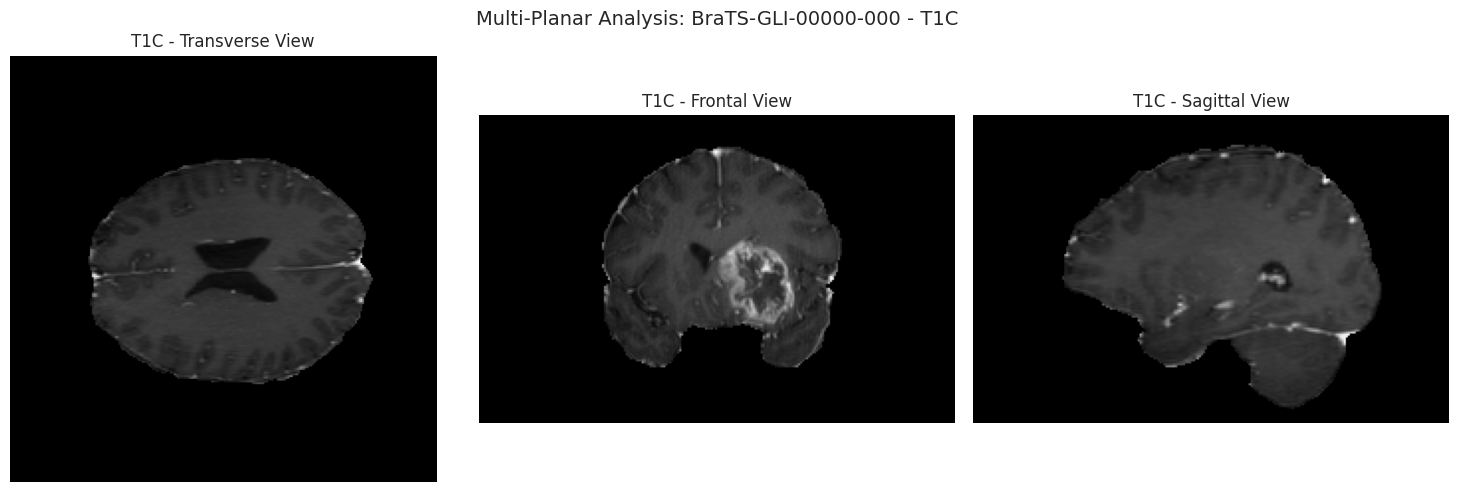


Analyzing T2W:
Slice number: 95
Image shape: (240, 240, 155)


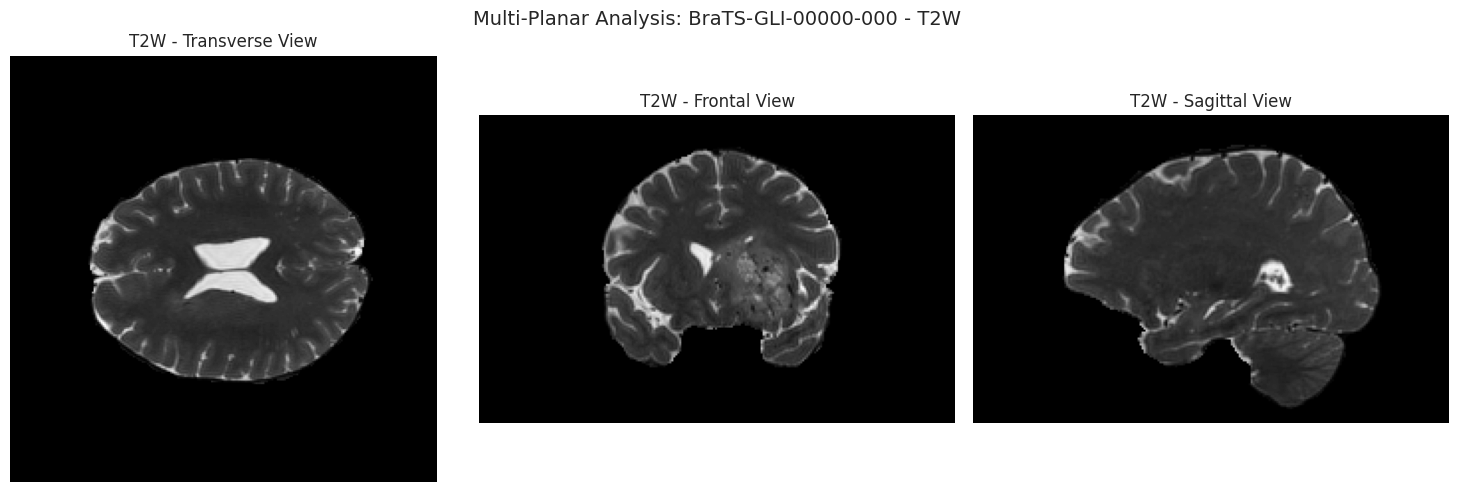


Analyzing T2F:
Slice number: 95
Image shape: (240, 240, 155)


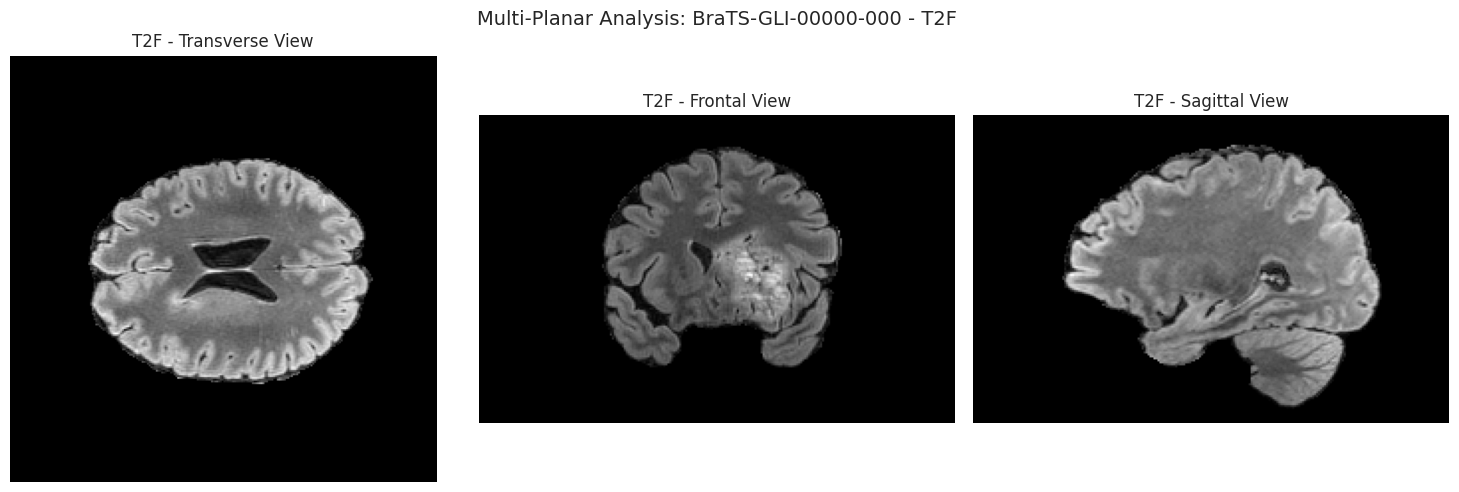

In [22]:
def visualize_multiplanar_view(patient_id, modality='t1c', slice_idx=95):
    """
    Display multi-planar views (transverse, frontal, sagittal) for a specific modality
    """
    # Load the specified modality data
    folder = os.path.join(DATA_DIR, patient_id)
    mod_path = os.path.join(folder, f"{patient_id}-{modality}.nii")
    
    if os.path.isdir(mod_path):
        nii_files = [f for f in os.listdir(mod_path) if f.endswith(".nii")]
        if nii_files:
            mod_path = os.path.join(mod_path, nii_files[0])
    
    if not os.path.exists(mod_path):
        print(f"Modality file not found: {mod_path}")
        return
    
    # Load image data
    img_data = nib.load(mod_path).get_fdata()
    
    print(f"Slice number: {slice_idx}")
    print(f"Image shape: {img_data.shape}")
    
    # Create multi-planar visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Transverse View (Axial)
    axes[0].imshow(img_data[:, :, slice_idx], cmap='gray')
    axes[0].set_title(f'{modality.upper()} - Transverse View', fontsize=12)
    axes[0].axis('off')
    
    # Frontal View (Coronal) - with rotation
    from scipy.ndimage import rotate
    frontal_slice = rotate(img_data[:, slice_idx, :], 90, reshape=True)
    axes[1].imshow(frontal_slice, cmap='gray')
    axes[1].set_title(f'{modality.upper()} - Frontal View', fontsize=12)
    axes[1].axis('off')
    
    # Sagittal View - with rotation
    sagittal_slice = rotate(img_data[slice_idx, :, :], 90, reshape=True)
    axes[2].imshow(sagittal_slice, cmap='gray')
    axes[2].set_title(f'{modality.upper()} - Sagittal View', fontsize=12)
    axes[2].axis('off')
    
    plt.suptitle(f"Multi-Planar Analysis: {patient_id} - {modality.upper()}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Compare different modalities
print("\n" + "="*60)
print("COMPARING MODALITIES ACROSS PLANES")
print("="*60)

for modality in ['t1n', 't1c', 't2w', 't2f']:
    print(f"\nAnalyzing {modality.upper()}:")
    visualize_multiplanar_view(sample_patient, modality=modality, slice_idx=95)


* Displays three orthogonal views (transverse, frontal, sagittal) for detailed spatial context
* Enables visual assessment of tumor location and morphology across planes
* Highlights intensity variations and anatomical landmarks per modality
* Facilitates quick comparison between different MRI sequences in the same slice
* Useful for verifying image alignment and segmentation overlay quality


## 7. MONTAGE VIEW OF ALL SLICES


Analyzing T1N:


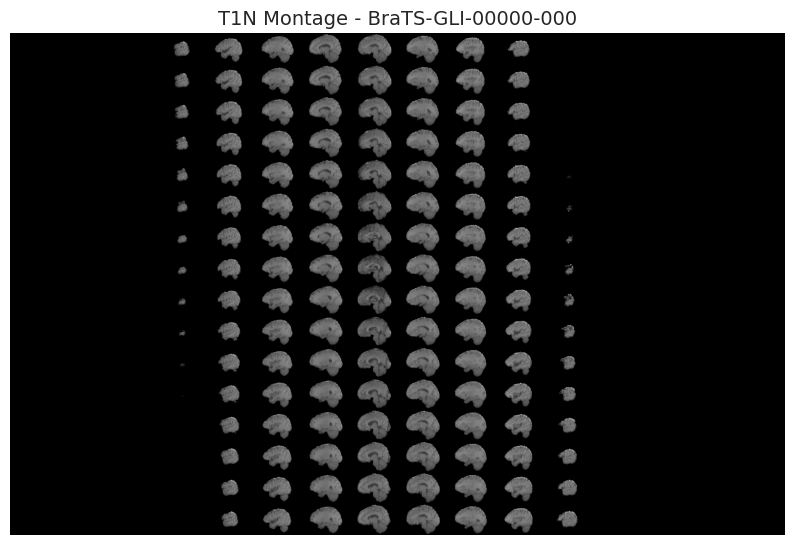


Analyzing T1C:


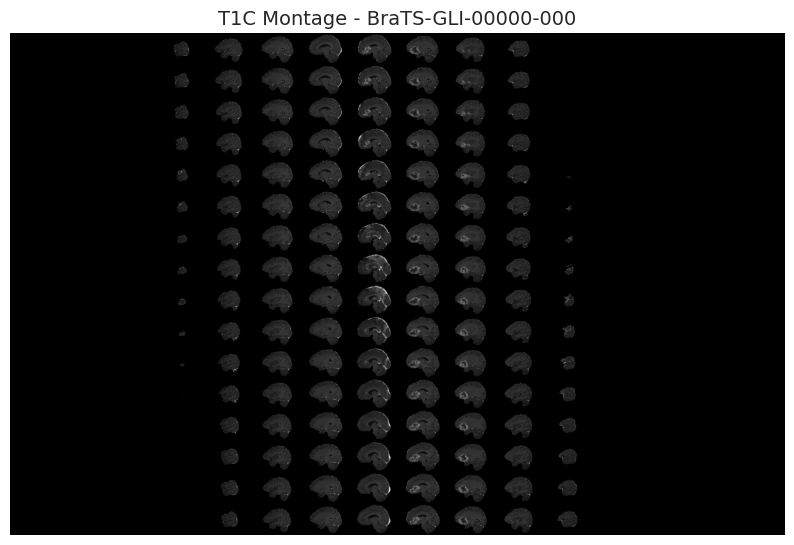


Analyzing T2W:


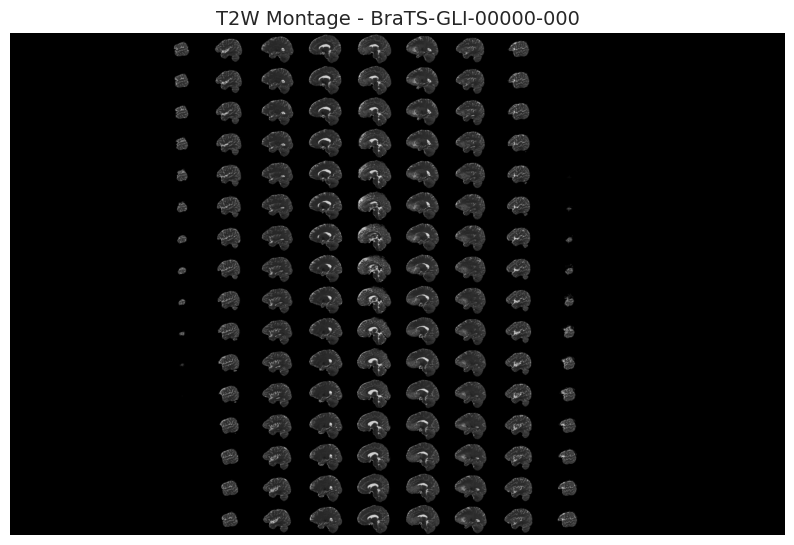


Analyzing T2F:


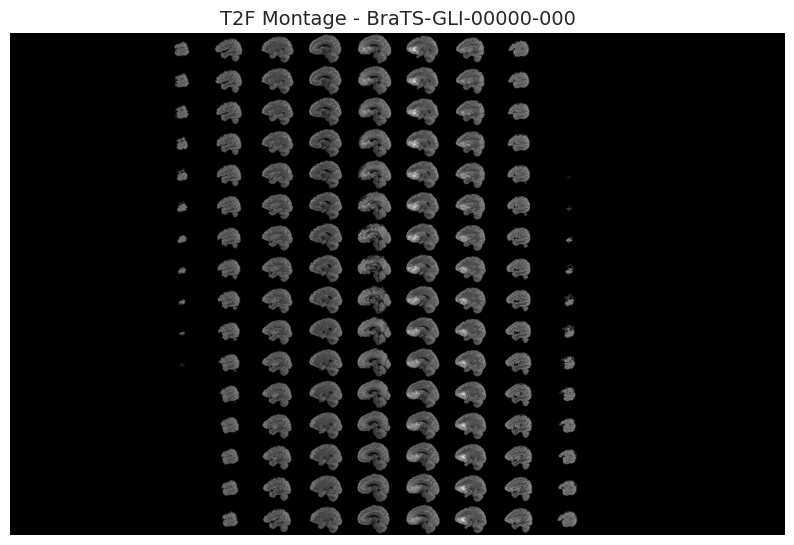

In [23]:
def visualize_montage(patient_id, modality='t1c'):
    """
    Display a montage of all axial slices for a specific modality,
    rotated for better visualization.
    """
    # Load image volume
    folder = os.path.join(DATA_DIR, patient_id)
    mod_path = os.path.join(folder, f"{patient_id}-{modality}.nii")
    
    if os.path.isdir(mod_path):
        nii_files = [f for f in os.listdir(mod_path) if f.endswith(".nii")]
        if nii_files:
            mod_path = os.path.join(mod_path, nii_files[0])
    
    if not os.path.exists(mod_path):
        print(f"Modality file not found: {mod_path}")
        return
    
    img_vol = nib.load(mod_path).get_fdata()
    
    # Create montage of all axial slices
    mont = montage(img_vol, grid_shape=None, padding_width=1, fill=0)
    mont_rot = rotate(mont, 90, reshape=True)
    
    # Plot montage
    plt.figure(figsize=(10, 10))
    plt.imshow(mont_rot, cmap='gray')
    plt.title(f"{modality.upper()} Montage - {patient_id}", fontsize=14)
    plt.axis('off')
    plt.show()

# Compare different modalities
for modality in ['t1n', 't1c', 't2w', 't2f']:
    print(f"\nAnalyzing {modality.upper()}:")
    visualize_montage(sample_patient, modality=modality)

* Many central slices display negligible tumor presence, indicating limited affected regions
* A few slices exhibit clear hyperintense regions, pinpointing the main tumor mass location
* Peripheral slices show mostly background and normal anatomy, confirming slice selection importance
* Montage highlights variability in tumor appearance across adjacent slices, suggesting heterogeneity
* Enables quick identification of critical slices for detailed analysis or model training

## 8. MASK OVERLAY ON A MODALITY

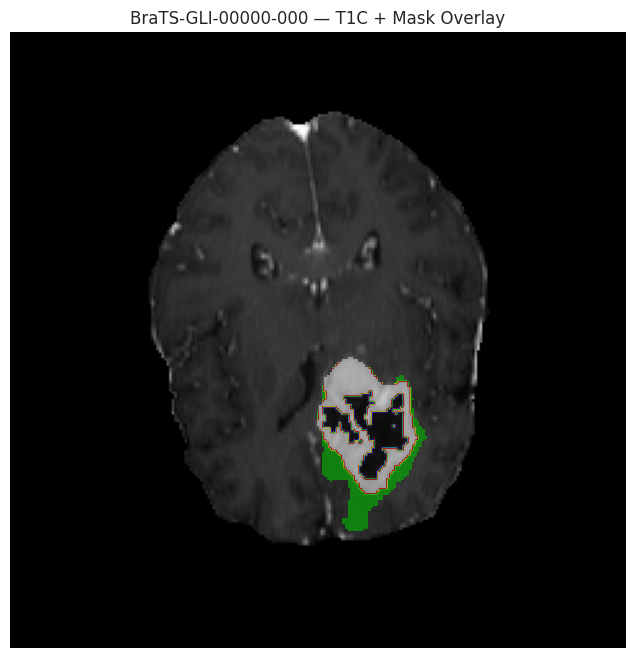

In [24]:
def overlay_mask(patient_id, modality="t1c"):
    folder = os.path.join(DATA_DIR, patient_id)

    # Load modality
    mod_folder = os.path.join(folder, f"{patient_id}-{modality}.nii")
    if os.path.isdir(mod_folder):
        nii_files = [f for f in os.listdir(mod_folder) if f.endswith(".nii")]
        if not nii_files:
            return
        img_path = os.path.join(mod_folder, nii_files[0])
    else:
        img_path = mod_folder
    
    img = nib.load(img_path).get_fdata()
    mid = img.shape[2] // 2

    # Load segmentation if exists
    seg_path = os.path.join(folder, f"{patient_id}-seg.nii")
    seg = None
    if os.path.exists(seg_path):
        if os.path.isdir(seg_path):
            seg_files = [f for f in os.listdir(seg_path) if f.endswith(".nii")]
            if seg_files:
                seg_path = os.path.join(seg_path, seg_files[0])
        seg = nib.load(seg_path).get_fdata()
    
    plt.figure(figsize=(8, 8))
    plt.imshow(img[:, :, mid].T, cmap='gray', origin='lower')
    if seg is not None:
        plt.imshow(np.ma.masked_where(seg[:, :, mid]==0, seg[:, :, mid]).T,
                   cmap='nipy_spectral', alpha=0.6, origin='lower')
        plt.title(f"{patient_id} — {modality.upper()} + Mask Overlay")
    else:
        plt.title(f"{patient_id} — {modality.upper()} (No Mask)")
    plt.axis('off')
    plt.show()

overlay_mask(sample_patient, modality="t1c")


* Created tumor mask overlays on brain images
* Demonstrated spatial relationship between tumor regions and anatomical structures
* Validated segmentation accuracy through visual inspection
* Confirmed proper alignment between imaging modalities and masks


## 9. INTENSITY DISTRIBUTION ACROSS SAMPLE PATIENTS

In [25]:
dist_records = []
for pid in tqdm(patients[:10], desc="Sampling patients"):
    folder = os.path.join(DATA_DIR, pid)
    for mod in MODALITIES:
        mod_folder = os.path.join(folder, f"{pid}-{mod}.nii")
        if os.path.isdir(mod_folder):
            nii_files = [f for f in os.listdir(mod_folder) if f.endswith(".nii")]
            if not nii_files:
                continue
            fpath = os.path.join(mod_folder, nii_files[0])
        elif os.path.exists(mod_folder):
            fpath = mod_folder
        else:
            continue

        img = nib.load(fpath).get_fdata()
        vals = img[np.isfinite(img)]
        dist_records.append({
            "Patient": pid,
            "Modality": mod,
            "Mean": np.mean(vals),
            "Std": np.std(vals),
            "Min": np.min(vals),
            "Max": np.max(vals),
            "P99": np.percentile(vals, 99)
        })

df_intensity = pd.DataFrame(dist_records)
df_intensity.head()

Sampling patients:   0%|          | 0/10 [00:00<?, ?it/s]

,Patient,Modality,Mean,Std,Min,Max,P99
0,BraTS-GLI-00000-000,t1n,132.997986,306.417500,0.0,2023.0,1015.0
1,BraTS-GLI-00000-000,t1c,345.505903,846.789962,0.0,12343.0,2959.0
2,BraTS-GLI-00000-000,t2w,93.782364,245.851136,0.0,2421.0,1152.0
3,BraTS-GLI-00000-000,t2f,163.657516,394.948503,0.0,2934.0,1492.0
4,BraTS-GLI-00002-000,t1n,104.642180,250.153062,0.0,2300.0,854.0


* T1-contrast consistently shows highest mean intensities across patients
* High standard deviations indicate significant intensity variations within each modality
* 99th percentile values provide guidance for outlier handling in preprocessing

## 10. PLOT INTENSITY STATISTICS

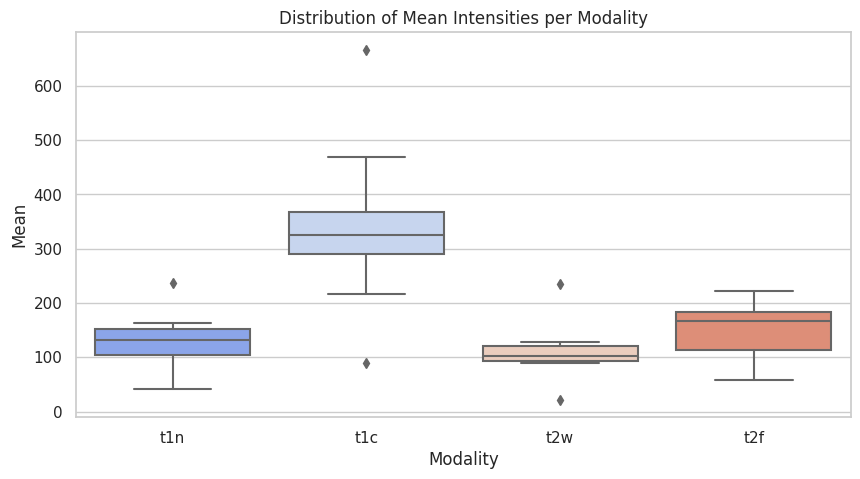

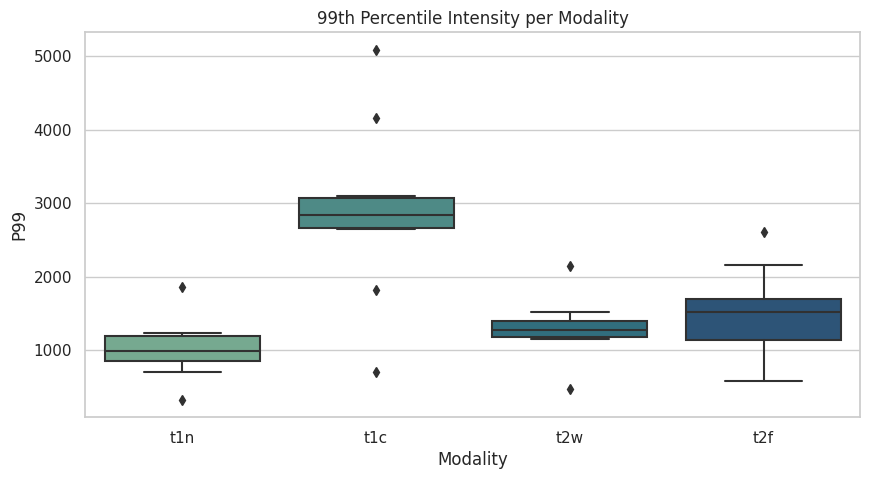

In [26]:
plt.figure(figsize=(10,5))
sns.boxplot(data=df_intensity, x="Modality", y="Mean", palette="coolwarm")
plt.title("Distribution of Mean Intensities per Modality")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(data=df_intensity, x="Modality", y="P99", palette="crest")
plt.title("99th Percentile Intensity per Modality")
plt.show()

* T1-contrast (T1c) exhibits the widest intensity range, with long tails reflecting high-intensity contrast-enhanced regions
* T2-FLAIR (T2f) shows broader distribution than T1-native and T2-weighted, indicating varied fluid/edema signal intensities
* T1-native (T1n) presents a narrow, skewed distribution concentrated at lower intensities, highlighting limited soft-tissue contrast
* T2-weighted (T2w) displays the lowest mean intensity and a tight distribution, consistent with its dark cerebrospinal fluid signal
* Box plots reveal outliers in T1c and T2f, underscoring the need for robust normalization or outlier clipping during preprocessing

## 11. IMAGE SHAPE & VOXEL SPACING VARIABILITY

In [27]:
shape_list, spacing_list = [], []
for pid in tqdm(patients[:20], desc="Collecting metadata"):
    mod_folder = os.path.join(DATA_DIR, pid, f"{pid}-t1n.nii")
    if os.path.isdir(mod_folder):
        nii_files = [f for f in os.listdir(mod_folder) if f.endswith(".nii")]
        if not nii_files:
            continue
        path = os.path.join(mod_folder, nii_files[0])
    elif os.path.exists(mod_folder):
        path = mod_folder
    else:
        continue

    img = nib.load(path)
    shape_list.append(img.shape)
    spacing_list.append(img.header.get_zooms())

df_shape = pd.DataFrame(shape_list, columns=["X","Y","Z"])
df_spacing = pd.DataFrame(spacing_list, columns=["dx","dy","dz"])
display(df_shape.describe())
display(df_spacing.describe())

,X,Y,Z
count,20.0,20.0,20.0
mean,240.0,240.0,155.0
std,0.0,0.0,0.0
min,240.0,240.0,155.0
25%,240.0,240.0,155.0
50%,240.0,240.0,155.0
75%,240.0,240.0,155.0
max,240.0,240.0,155.0


,dx,dy,dz
count,20.0,20.0,20.0
mean,1.0,1.0,1.0
std,0.0,0.0,0.0
min,1.0,1.0,1.0
25%,1.0,1.0,1.0
50%,1.0,1.0,1.0
75%,1.0,1.0,1.0
max,1.0,1.0,1.0


* Results confirm zero variability in spatial properties, indicating excellent preprocessing quality

## 12. SEGMENTATION CLASS DISTRIBUTION

In [28]:
tumor_counts = {1:0, 2:0, 3:0}
total_voxels = 0

for pid in tqdm(patients[:10], desc="Counting tumor classes"):
    seg_path = os.path.join(DATA_DIR, pid, f"{pid}-seg.nii")
    if not os.path.exists(seg_path):
        continue
    if os.path.isdir(seg_path):
        seg_files = [f for f in os.listdir(seg_path) if f.endswith(".nii")]
        if not seg_files:
            continue
        seg_path = os.path.join(seg_path, seg_files[0])
    seg = nib.load(seg_path).get_fdata().astype(int)
    total_voxels += np.prod(seg.shape)
    for cls in [1,2,3]:
        tumor_counts[cls] += np.sum(seg==cls)

for cls, count in tumor_counts.items():
    print(f"Class {cls}: {count} voxels ({count/total_voxels*100:.2f}%)")

Counting tumor classes:   0%|          | 0/10 [00:00<?, ?it/s]

Class 1: 90310 voxels (0.10%)
Class 2: 532555 voxels (0.60%)
Class 3: 145683 voxels (0.16%)


* Severe class imbalance: Tumor regions represent less than 1% of total volume
* Class 2 (edema) dominates tumor volume, representing 60% of all tumor voxels
* Combined tumor classes account for only 0.86% of total brain volume
* This distribution necessitates specialized loss functions and sampling strategies for model training